In [1]:
import osmnx as ox
import geopandas as gpd
import numpy as npm
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point
from shapely.geometry import LineString
from shapely.geometry import MultiLineString
from collections import deque
import datetime

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [695]:
CRS_PLOT = 'EPSG:4326'
DATA_DIR = '../data'
EXPORTS_DIR = f'{DATA_DIR}/exports'
ROUTE = 'b41'

In [696]:
stops_df = pd.read_csv(f'{DATA_DIR}/20210817_stops.txt')
stop_times_df = pd.read_csv(f'{DATA_DIR}/20210817_stop_times.txt')
stop_times_df = stop_times_df.drop(columns=['departure_time', 'pickup_type', 'drop_off_type']).rename(columns={'arrival_time': 'time'})

In [697]:
stop_times_df = stop_times_df[stop_times_df['trip_id'].str.contains(f'_{ROUTE.upper()}_')]
stop_times_df = stop_times_df[stop_times_df['trip_id'].str.contains(f'Weekday')]

In [740]:
INDEX = 28
trip_ids = stop_times_df.groupby(by=['trip_id']).agg('first')
trip_ids.head()

,time,stop_id,stop_sequence
trip_id,,,
FB_C1-Weekday-004500_B41_201,00:45:00,303215,1
FB_C1-Weekday-006300_B41_202,01:03:00,308381,1
FB_C1-Weekday-009000_B41_201,01:30:00,307403,1
FB_C1-Weekday-009500_B41_203,01:35:00,303215,1
FB_C1-Weekday-012000_B41_202,02:00:00,307403,1


In [741]:
matching_routes_df = stop_times_df[stop_times_df['trip_id'] == trip_ids.index[INDEX]]
matching_routes_df.head()

,trip_id,time,stop_id,stop_sequence
342080,FB_C1-Weekday-035800_B41_207,05:58:00,307403,1
342081,FB_C1-Weekday-035800_B41_207,06:01:06,307460,2
342082,FB_C1-Weekday-035800_B41_207,06:02:48,308845,3
342083,FB_C1-Weekday-035800_B41_207,06:03:39,306901,4
342084,FB_C1-Weekday-035800_B41_207,06:05:44,303294,5


In [742]:
matching_route_trip_ids = list(set(matching_routes_df['trip_id']))
single_route_df = stop_times_df[stop_times_df['trip_id'] == matching_route_trip_ids[0]]
route_stop_first = single_route_df.iloc[0]['stop_id']
route_stop_last = single_route_df.iloc[-1]['stop_id']
route_length = int(single_route_df.iloc[-1]['stop_sequence']) - 1


In [743]:
stop_times_idf = stop_times_df.set_index(['trip_id', 'stop_sequence'])
stop_times_idf

time  stop_id
trip_id                           stop_sequence                   
FB_C1-Weekday-145400_B41_281      1              24:14:00   308381
                                  2              24:14:38   303269
                                  3              24:15:16   303270
                                  4              24:15:48   303271
                                  5              24:16:20   303272
...                                                   ...      ...
FB_C1-Weekday-SDon-117800_B41_246 16             19:54:09   303333
                                  17             19:54:58   303334
                                  18             19:55:33   303335
                                  19             19:56:27   307895
                                  20             19:57:00   303337

[34252 rows x 2 columns]

In [744]:
starts_df = stop_times_df[stop_times_df['stop_sequence'] == 1].drop(columns=['stop_sequence'])

In [745]:
b_starts_df = stop_times_df[(stop_times_df['stop_id'] == route_stop_first) & (stop_times_df['stop_sequence'] == 1)]
b_ends_df = stop_times_df[(stop_times_df['stop_id'] == route_stop_last) & (stop_times_df['stop_sequence'] == route_length + 1)]

b_starts_df = b_starts_df[b_starts_df['time'].str[0:2].astype(int) < 24]
b_end_df = b_starts_df[b_starts_df['time'].str[0:2].astype(int) < 24]

b_trip_ids = pd.merge(b_starts_df[['trip_id']], b_ends_df[['trip_id']])
print(len(b_trip_ids))

128


In [746]:
b_stop_times_df = pd.merge(stop_times_df, b_trip_ids)
b_weekday_stop_times_df = b_stop_times_df[b_stop_times_df['trip_id'].str.contains('Weekday')]
b_weekday_stop_times_df = b_stop_times_df[~b_stop_times_df['trip_id'].str.contains('SDon')]
b_weekday_stop_times_idf = b_stop_times_df.set_index(['trip_id', 'stop_sequence'])
b_weekday_stop_times_idf

time  stop_id
trip_id                           stop_sequence                   
FB_C1-Weekday-024000_B41_202      1              04:00:00   307403
                                  2              04:02:47   307460
                                  3              04:04:19   308845
                                  4              04:05:05   306901
                                  5              04:06:57   303294
...                                                   ...      ...
FB_C1-Weekday-SDon-141700_B41_276 36             24:24:26   303339
                                  37             24:25:05   303340
                                  38             24:25:54   303341
                                  39             24:26:51   307636
                                  40             24:29:00   801144

[5120 rows x 2 columns]

In [747]:
b_stops = list(stop_times_df[stop_times_df['trip_id'] == b_starts_df.iloc[0]['trip_id']]['stop_id'])

In [748]:
df = b_weekday_stop_times_df
df = df.pivot(index='trip_id', columns='stop_id', values='time')

In [749]:
df = b_weekday_stop_times_df
df = df.pivot(index='trip_id', columns='stop_id', values='time')
#df = df[b_stops]
df = df.sort_values(by=[route_stop_first])
df = df.drop_duplicates(subset=[route_stop_first, route_stop_last], keep="last")
df

stop_id,302623,303294,303295,303297,303300,303301,303303,303306,303307,303308,...,307460,307516,307636,307646,308061,308369,308557,308845,801144,901500
trip_id,,,,,,,,,,,,,,,,,,,,,
FB_C1-Weekday-012000_B41_202,02:16:43,02:06:57,02:09:00,02:10:11,02:11:12,02:11:42,02:15:04,02:17:47,02:18:53,02:19:54,...,02:02:47,02:33:13,02:39:12,02:16:00,02:12:13,02:21:00,02:34:27,02:04:19,02:41:00,02:09:39
FB_C1-Weekday-018000_B41_204,03:16:43,03:06:57,03:09:00,03:10:11,03:11:12,03:11:42,03:15:04,03:17:47,03:18:53,03:19:54,...,03:02:47,03:33:13,03:39:12,03:16:00,03:12:13,03:21:00,03:34:27,03:04:19,03:41:00,03:09:39
FB_C1-Weekday-024000_B41_202,04:16:43,04:06:57,04:09:00,04:10:11,04:11:12,04:11:42,04:15:04,04:17:47,04:18:53,04:19:54,...,04:02:47,04:33:46,04:40:12,04:16:00,04:12:13,04:21:00,04:35:12,04:04:19,04:42:00,04:09:39
FB_C1-Weekday-029500_B41_204,05:13:52,05:02:44,05:05:00,05:06:22,05:07:30,05:08:05,05:11:56,05:15:08,05:16:28,05:17:40,...,04:58:06,05:32:46,05:41:08,05:13:00,05:08:41,05:19:00,05:34:12,04:59:48,05:44:00,05:05:45
FB_C1-Weekday-032800_B41_201,05:46:52,05:35:44,05:38:00,05:39:22,05:40:30,05:41:05,05:44:56,05:48:08,05:49:28,05:50:40,...,05:31:06,06:06:18,06:15:08,05:46:00,05:41:41,05:52:00,06:07:56,05:32:48,06:18:00,05:38:45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FB_C1-Weekday-132100_B41_267,22:25:17,22:10:16,22:13:00,22:14:52,22:16:27,22:17:15,22:22:32,22:27:12,22:29:12,22:31:01,...,22:04:43,22:50:18,22:58:29,22:24:00,22:18:04,22:33:00,22:51:56,22:06:45,23:01:00,22:14:02
FB_C1-Weekday-134500_B41_269,22:49:17,22:34:16,22:37:00,22:38:52,22:40:27,22:41:15,22:46:32,22:51:12,22:53:12,22:55:01,...,22:28:43,23:14:18,23:21:51,22:48:00,22:42:04,22:57:00,23:15:56,22:30:45,23:24:00,22:38:02
FB_C1-Weekday-136900_B41_271,23:12:09,22:58:16,23:01:00,23:02:42,23:04:08,23:04:52,23:09:40,23:13:50,23:15:37,23:17:14,...,22:52:43,23:34:46,23:41:51,23:11:00,23:05:36,23:19:00,23:36:12,22:54:45,23:44:00,23:01:56


In [750]:
df.to_csv(f'{EXPORTS_DIR}/stop_times/{ROUTE}_weekday_stop_times.csv')

In [751]:
route_df = pd.merge(df.iloc[0, :], stops_df, on='stop_id', how='left')
route_df

,stop_id,FB_C1-Weekday-012000_B41_202,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station
0,302623,02:16:43,FLATBUSH AV/LINCOLN RD,NaN,40.660947,-73.961001,NaN,NaN,0,NaN
1,303294,02:06:57,LIVINGSTON ST/NEVINS ST,NaN,40.687645,-73.980819,NaN,NaN,0,NaN
2,303295,02:09:00,FLATBUSH AV/ATLANTIC AV,NaN,40.684187,-73.977626,NaN,NaN,0,NaN
3,303297,02:10:11,FLATBUSH AV/BERGEN ST,NaN,40.680464,-73.974971,NaN,NaN,0,NaN
4,303300,02:11:12,FLATBUSH AV/PARK PL,NaN,40.677359,-73.972665,NaN,NaN,0,NaN
5,303301,02:11:42,FLATBUSH AV/8 AV,NaN,40.675771,-73.971508,NaN,NaN,0,NaN
6,303303,02:15:04,FLATBUSH AV/PROSPECT PARK ENT,NaN,40.665554,-73.964232,NaN,NaN,0,NaN
7,303306,02:17:47,FLATBUSH AV/CHESTER CT,NaN,40.658183,-73.960552,NaN,NaN,0,NaN
8,303307,02:18:53,FLATBUSH AV/PARKSIDE AV,NaN,40.655257,-73.959894,NaN,NaN,0,NaN
9,303308,02:19:54,FLATBUSH AV/CATON AV,NaN,40.652597,-73.959366,NaN,NaN,0,NaN


In [752]:
route_gdf = gpd.GeoDataFrame(route_df, geometry=gpd.points_from_xy(route_df['stop_lon'], route_df['stop_lat']), crs=CRS_PLOT)
route_gdf.to_file(f'{EXPORTS_DIR}/stops/{ROUTE}_stops.shp')

<AxesSubplot:>

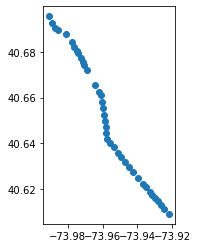

In [753]:
route_gdf.plot()